In [1]:
# general imports

import numpy as np
import pandas as pd
import time

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

# note that some models shuffle the learning data, so results may differ because I didn't know it and didn't set the seed
np.random.seed(314) #doesnt work

# disable warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Data

Data is provided [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00288/) along with a `readme` with data descrption.

## Data Pre-Processing

The dataset is already fine as it is, we can insert column names and remove the _Specimen Number_ as we don't need it.  

Since The data is presented grouped by _Species_, we can also shuffle the dataset (this is necessary later when we take folds of the dataset)

In [2]:
# load the data
ds = pd.read_csv("/home/brusa/Scratch/leaf.csv", header=None)

# column names
header = ['Species','Specimen Number', 'Eccentricity','Aspect Ratio','Elongation','Solidity','Stochastic Convexity','Isoperimetric Factor','Maximal Indentation Depth','Lobedness','Average Intensity','Average Contrast','Smoothness','Third moment','Uniformity','Entropy']
ds.columns = header

# remove specimen number
ds.pop('Specimen Number')

# shuffle the dataset
from sklearn.utils import shuffle
ds = shuffle(ds, random_state=1)

# Problem Statement

_Identify leaf species based on leaf attributes_

Formally we are searching for an $f$ such that:
$$ f : \mathbb{R}^{14} \rightarrow \{ \text{species}_i | i=1, \dots, 30 \} $$  
So we need to classify leaves based on 14 numerical attributes in one of the 30 possible leaf species. It's a multiclass classification problem.

In [35]:
# we have 30 different species  in the dataset
print("|Y| =",len(set(ds.Species)))

#observation count min max
print("min =", min(ds.value_counts('Species')))
print("max =", max(ds.value_counts('Species')))

|Y| = 30
min = 8
max = 16


## Single Tree

bla lba

In [45]:
%%timeit

param_grid = {"criterion":['gini', 'entropy'],
             "min_samples_leaf" : [1,2,3,4,5], }

m = GridSearchCV(estimator= DecisionTreeClassifier(random_state=1), param_grid= param_grid, scoring= "balanced_accuracy", cv=10, refit=True)
m.fit(ds.drop('Species', axis=1), ds.Species)

print("tree: ",m.best_params_, " wacc =", m.best_score_ )

tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
tree:  {'criterion': 'gini', 'min_samples_leaf': 1}  wacc = 0.6166091954022989
1.66 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Random Forest

For our first resolution we will use the _Random Forest_ technique. It is a supervised learning technique.    
Altough RF has two parameters $n_\text{trees}, n_\text{vars}$, it can be considered as an hyperparameter free learning technique, as it can be proven that the best parameters are $ n_\text{trees} = 500, n_\text{vars} = \sqrt{p}$ (for classification).


In [37]:
#manual CV to see if it matches

k = 10
kf = KFold(n_splits=k)

# to store all scores
ACCs = []
WACCs = []

fold = kf.split(ds) # gives an iterator object

for n_fold in range(k):
    
    # get the train/test datasets
    result = next(fold)
    
    learn = ds.iloc[result[0]]
    test = ds.iloc[result[1]]
    
    # create model
    m = RandomForestClassifier(n_estimators= 500, min_samples_leaf= 1, max_features="sqrt")
    
    # fit model
    m.fit(learn.drop('Species', axis=1), learn.Species)
    
    # get ACC and WACC
    ACCs.append(m.score(test.drop('Species', axis=1), test.Species))
    WACCs.append(balanced_accuracy_score(test.Species, m.predict(test.drop('Species', axis=1))))

# save
print(np.mean(ACCs), np.std(ACCs),np.mean(WACCs),np.std(WACCs))

0.75 0.042111238421401014 0.7581206639787875 0.032184584484595206


In [38]:
%%timeit

m = GridSearchCV(estimator= RandomForestClassifier(), param_grid= {"n_estimators":[500]}, scoring= "balanced_accuracy", cv=10, refit=True)
m.fit(ds.drop('Species', axis=1), ds.Species)

print("RF: ",m.best_params_, " wacc =", m.best_score_ )

RF:  {'n_estimators': 500}  wacc = 0.7902504105090311
RF:  {'n_estimators': 500}  wacc = 0.7853694581280787
RF:  {'n_estimators': 500}  wacc = 0.7751354679802955
RF:  {'n_estimators': 500}  wacc = 0.7904802955665025
RF:  {'n_estimators': 500}  wacc = 0.7886412151067324
RF:  {'n_estimators': 500}  wacc = 0.8004802955665026
RF:  {'n_estimators': 500}  wacc = 0.7972085385878489
RF:  {'n_estimators': 500}  wacc = 0.7885262725779966
16.8 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Suport Vector Machines

For our second resolution we will use the _SVM_ technique. It is a supervised learning technique.  
We use the generalized versions of the _SVM_, which supports multiclass classification using the **one versus one**  approach.  

The technique itself has just one parameter: the _cost_ $c$, but we can also choose to use a _kernel function_, for which we have various options.  

It is also recomended to scale the data.

In [39]:
%%timeit

## Linear

# create pipelined model
m1 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC()),
])

param_grid1 = {'svm__C': (0.1, 0.5, 1, 5, 10, 50, 100, 250, 500, 750, 1000),}

model1 = GridSearchCV(estimator= m1, param_grid= param_grid1, scoring= "balanced_accuracy", cv=10, refit=True)
model1.fit(ds.drop('Species', axis=1), ds.Species)

print("linear:",model1.best_params_, " wacc =", model1.best_score_ )

# create pipelined model
m2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC()),
])

linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
linear: {'svm__C': 5}  wacc = 0.8442857142857143
8.86 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit

## poly

# create pipelined model
m3 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC()),
])

param_grid3 = {'svm__C': (0.1, 0.5, 1, 5, 10, 50, 100, 250, 500, 750, 1000),
              'svm__kernel' : ['poly'],
              'svm__degree' : (2, 3, 4, 5, 6, 7, 8),}

model3 = GridSearchCV(estimator= m3, param_grid= param_grid3, scoring= "balanced_accuracy", cv=10, refit=True)
model3.fit(ds.drop('Species', axis=1), ds.Species)

print("polynomial: ",model3.best_params_, " wacc =", model3.best_score_ )

polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
polynomial:  {'svm__C': 50, 'svm__degree': 2, 'svm__kernel': 'poly'}  wacc = 0.7600779967159277
17.7 s ± 498 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit

## Gaussian

# create pipelined model
m2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC()),
])

param_grid2 = {'svm__C': (0.1, 0.5, 1, 5, 10, 50, 100, 250, 500, 750, 1000),
              'svm__kernel' : ['rbf'],
              'svm__gamma' : (0.01, 0.001, 0.0001),}

model2 = GridSearchCV(estimator= m2, param_grid= param_grid2, scoring= "balanced_accuracy", cv=10, refit=True)
model2.fit(ds.drop('Species', axis=1), ds.Species)

print("gaussian: ",model2.best_params_, " wacc =", model2.best_score_ )

gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
gaussian:  {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}  wacc = 0.7822742200328408
8.41 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## K-Nearest Neighbours

bla bla bla

In [42]:
%%timeit

param_grid = {'n_neighbors': np.arange(1,30),
             'metric': ['euclidean', 'manhattan'],}

m = GridSearchCV(estimator= KNeighborsClassifier(), param_grid= param_grid, scoring= "balanced_accuracy", cv=10, refit=True)
m.fit(ds.drop('Species', axis=1), ds.Species)

print("knn: ",m.best_params_, " wacc =", m.best_score_ )

knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
knn:  {'metric': 'manhattan', 'n_neighbors': 1}  wacc = 0.6516707717569786
5.15 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# All Out Comparison

In [48]:
models_labels = ['Tree','Random Forest','Linear SVM', 'Polynomial SVM', 'Gaussian SVM', 'kNN']
models=[DecisionTreeClassifier(criterion='gini', min_samples_leaf=1),
        RandomForestClassifier(n_estimators= 500, min_samples_leaf= 1, max_features="sqrt"),
        Pipeline([("scaler", StandardScaler()),("svm", LinearSVC(C=5)),]),
        Pipeline([("scaler", StandardScaler()),("svm", SVC(C=50, degree=2, kernel='poly')),]),
        Pipeline([("scaler", StandardScaler()),("svm", SVC(C=1000, gamma=0.01, kernel='rbf')),]),
        KNeighborsClassifier(metric='manhattan', n_neighbors=1),
       ]
ACCs = []
ACCs_sd = []
wACCs = [] 
wACCs_sd = []
times=[]


# cross fold iterator
k = 10
kf = KFold(n_splits=k)

for i in range(len(models)):
    # to store all scores
    mACCs = []
    mWACCs = []
    mtimes = []

    fold = kf.split(ds) # gives an iterator object
    
    for n_fold in range(k):
        # get the train/test datasets
        result = next(fold)

        learn = ds.iloc[result[0]]
        test = ds.iloc[result[1]]
        
        #to make sure that it is working with the same learn\test
        #print(result[1])

        # fit model
        start = time.time()
        models[i].fit(learn.drop('Species', axis=1), learn.Species)
        end = time.time()
        
        mtimes.append(end-start)

        # get ACC and WACC
        mACCs.append(models[i].score(test.drop('Species', axis=1), test.Species))
        mWACCs.append(balanced_accuracy_score(test.Species, models[i].predict(test.drop('Species', axis=1))))
    
    ACCs.append(np.mean(mACCs))
    wACCs.append(np.mean(mWACCs))
    ACCs_sd.append(np.std(mACCs))
    wACCs_sd.append(np.std(mWACCs))
    times.append(np.mean(mtimes))
    #print("---------------------------------------------")

In [49]:
### create dataframe

data =np.array([ACCs, ACCs_sd, wACCs, wACCs_sd])

pd.options.display.float_format = '{:.2%}'.format
#data = data * 100
#data = np.around(data, decimals=3)

df = pd.DataFrame(data=data.T, index=models_labels, columns=['Accuracy Mean', 'Accuracy SD', 'W. Accuracy Mean', 'W. Accuracy SD'])
df

,Accuracy Mean,Accuracy SD,W. Accuracy Mean,W. Accuracy SD
Tree,62.94%,7.23%,62.29%,6.13%
Random Forest,76.76%,4.25%,77.37%,3.38%
Linear SVM,84.71%,6.14%,86.08%,6.29%
Polynomial SVM,73.24%,5.49%,74.94%,6.14%
Gaussian SVM,77.65%,4.40%,78.66%,3.98%
kNN,62.35%,6.94%,62.62%,7.60%


# PLOTTING

In [51]:
# same but with timing and data gathered for plotting

models_labels = ['Tree','Random Forest','Linear SVM', 'Polynomial SVM', 'Gaussian SVM', 'kNN']
models=[DecisionTreeClassifier(criterion='gini', min_samples_leaf=1),
        RandomForestClassifier(n_estimators= 500, min_samples_leaf= 1, max_features="sqrt"),
        Pipeline([("scaler", StandardScaler()),("svm", LinearSVC(C=5)),]),
        Pipeline([("scaler", StandardScaler()),("svm", SVC(C=50, degree=2, kernel='poly')),]),
        Pipeline([("scaler", StandardScaler()),("svm", SVC(C=1000, gamma=0.01, kernel='rbf')),]),
        KNeighborsClassifier(metric='manhattan', n_neighbors=1),
       ]
ACCs = []
ACCs_sd = []
wACCs = [] 
wACCs_sd = []
times=[]


# cross fold iterator
k = 10
kf = KFold(n_splits=k)

for i in range(len(models)):
    # to store all scores
    mACCs = []
    mWACCs = []
    mtimes = []

    fold = kf.split(ds) # gives an iterator object
    
    for n_fold in range(k):
        # get the train/test datasets
        result = next(fold)

        learn = ds.iloc[result[0]]
        test = ds.iloc[result[1]]
        
        #to make sure that it is working with the same learn\test
        #print(result[1][:5])

        # fit model
        start = time.time()
        models[i].fit(learn.drop('Species', axis=1), learn.Species)
        end = time.time()
        
        mtimes.append(end-start)

        # get ACC and WACC
        mACCs.append(models[i].score(test.drop('Species', axis=1), test.Species))
        mWACCs.append(balanced_accuracy_score(test.Species, models[i].predict(test.drop('Species', axis=1))))
    
    ACCs.append(mACCs)
    wACCs.append(mWACCs)
    times.append(mtimes)

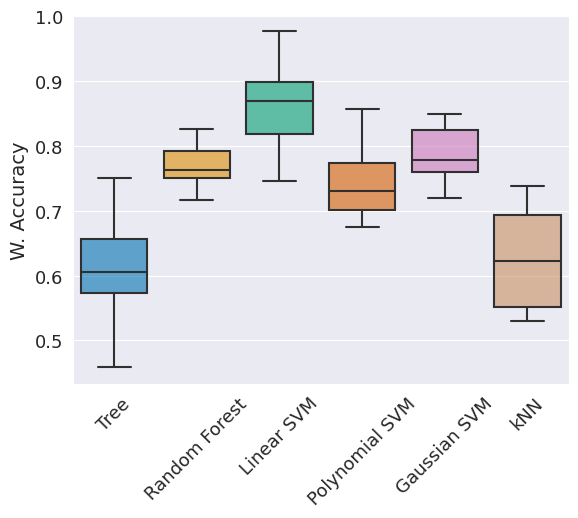

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')        # darkgrid, whitegrid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

ax = sns.boxplot(wACCs, palette=sns.color_palette("colorblind"), saturation=1)
ax.set_ylabel("W. Accuracy")
ax.set_xticklabels(models_labels, rotation=45)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
plt.show()